# NeuralODE on Solar System orbits

Here is [astroNN](https://github.com/henrysky/astroNN), please take a look if you are interested in astronomy or how neural network applied in astronomy
* **Henry Leung** - *Astronomy student, University of Toronto* - [henrysky](https://github.com/henrysky)
* Project adviser: **Jo Bovy** - *Professor, Department of Astronomy and Astrophysics, University of Toronto* - [jobovy](https://github.com/jobovy)
* Contact Henry: henrysky.leung [at] utoronto.ca
* This tutorial is created on 13/Apr/2020 with pytorch 1.4.0, torchdiffeq 0.0.1, galpy 1.6.0

In this demo, we give orbits of planets except Earth as training data. You can see the neural ODE is learning how to integrate Earth orbit by watching how other planets are orbiting, meaning the nerual ODE is learning the ODE system of equation for our Solar System.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import numpy as np
import pylab as plt
import astropy.units as u
from galpy.orbit import Orbit
from galpy.potential import KeplerPotential

# select all planet except Earth
os = Orbit.from_name("solar system")[[0,1,3,4,5,6,7]]
o_earth = Orbit.from_name("solar system")[2]

# training size
size = 1000
# training orbits time in years
t = np.linspace(0, 10, size)
os.integrate(pot=KeplerPotential(amp=1.), t=t*u.yr)
o_earth.integrate(pot=KeplerPotential(amp=1.), t=t*u.yr)

# initial conditions including the Earth as a validaiton
earth_y0 = np.array([(o_earth.R()*u.kpc).to(u.AU).value, o_earth.phi(), o_earth.vR(), o_earth.vphi()]).T
true_y0 = np.array([(os.R()*u.kpc).to(u.AU).value, os.phi(), os.vR(), os.vphi()]).T
# need to use unwrap as neural net cannot handle discontinuity of phase wrapping
true_y = np.swapaxes(np.array([(os.R(t*u.yr)*u.kpc).to(u.AU).value, np.unwrap(os.phi(t*u.yr)), os.vR(t*u.yr), os.vphi(t*u.yr)]).T, 0, 1)

fig = plt.figure(figsize=(7.5, 7.5))
ax = fig.gca()
plt.title("Solar System training orbits")
plt.scatter((os.x(t*u.yr)*u.kpc).to(u.AU), (os.y(t*u.yr)*u.kpc).to(u.AU), s=0.1)
plt.xlabel("x (AU)")
plt.ylabel("y (AU)")
ax.set_aspect("equal")
plt.tight_layout()

In [ ]:
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint

# batch size
ts_size = 20

device = torch.device('cuda:' + str(0) if torch.cuda.is_available() else 'cpu')


class ODEFunc(nn.Module):
    """
    Neural Net of the ODE function
    
    4 inputs [r, phi, vr, vphi] -> 4 outputs [vr, vphi, ar, aphi]
    """
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(nn.Linear(4, 16), 
                                 nn.ReLU(),
                                 nn.Linear(16, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, 16),
                                 nn.ReLU(),
                                 nn.Linear(16, 4)).to(device)

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

    
def get_batch():
    # randomly choosing 64 starting index in planet, time index
    s = torch.from_numpy(np.random.choice(np.arange(size - ts_size, dtype=np.int64), 64, replace=False))
    rand_planet = np.random.randint(0, 7, 64)
    batch_y0 = torch.Tensor(true_y[rand_planet][:, s, :])  # (M, D)
    batch_t = torch.Tensor(t[:ts_size])  # (T)
    batch_y = torch.Tensor(torch.stack([torch.Tensor(true_y[rand_planet][:, s+i, :]) for i in range(ts_size)], dim=0))  # (T, M, D)
    return batch_y0, batch_t, batch_y

ii = 0

func = ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
end = time.time()

r = (o_earth.R(t*u.yr)*u.kpc).to(u.AU)
phi = o_earth.phi(t*u.yr)
x = r*np.cos(phi)
y = r*np.sin(phi)

x2 = (os.x(t*u.yr)*u.kpc).to(u.AU)
y2 = (os.y(t*u.yr)*u.kpc).to(u.AU)

for itr in range(1, 150 + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0.to(device), batch_t.to(device))
    loss = torch.mean(torch.abs(pred_y - batch_y.to(device))).to(device)
    loss.backward()
    optimizer.step()

    if itr % 10 == 0:
        with torch.no_grad():
            pred_y = odeint(func, torch.Tensor(earth_y0).to(device), torch.Tensor(np.linspace(0, 1, size)).to(device))
            loss = torch.mean(torch.abs(pred_y - torch.Tensor(true_y).to(device))).to(device)
            pred = pred_y.detach().cpu().numpy()
            pred_x_pos = pred[:, 0]*np.cos(pred[:, 1])
            pred_y_pos = pred[:, 0]*np.sin(pred[:, 1])
            print(f'Iteration: {itr} | Total Loss {loss.item():.6f}')
            ii += 1
        fig = plt.figure(figsize=(5, 5))
        ax = fig.gca()
        plt.title(f"Iteration {itr}")
        plt.plot(x, y, label='galpy (Earth)')
        plt.plot(pred_x_pos, pred_y_pos, ls='--', label='Prediction (Earth)')
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xlabel("x (AU)")
        plt.ylabel("y (AU)")
        plt.legend()
        ax.set_aspect('equal')
        plt.show()
        plt.close("all")

    end = time.time()

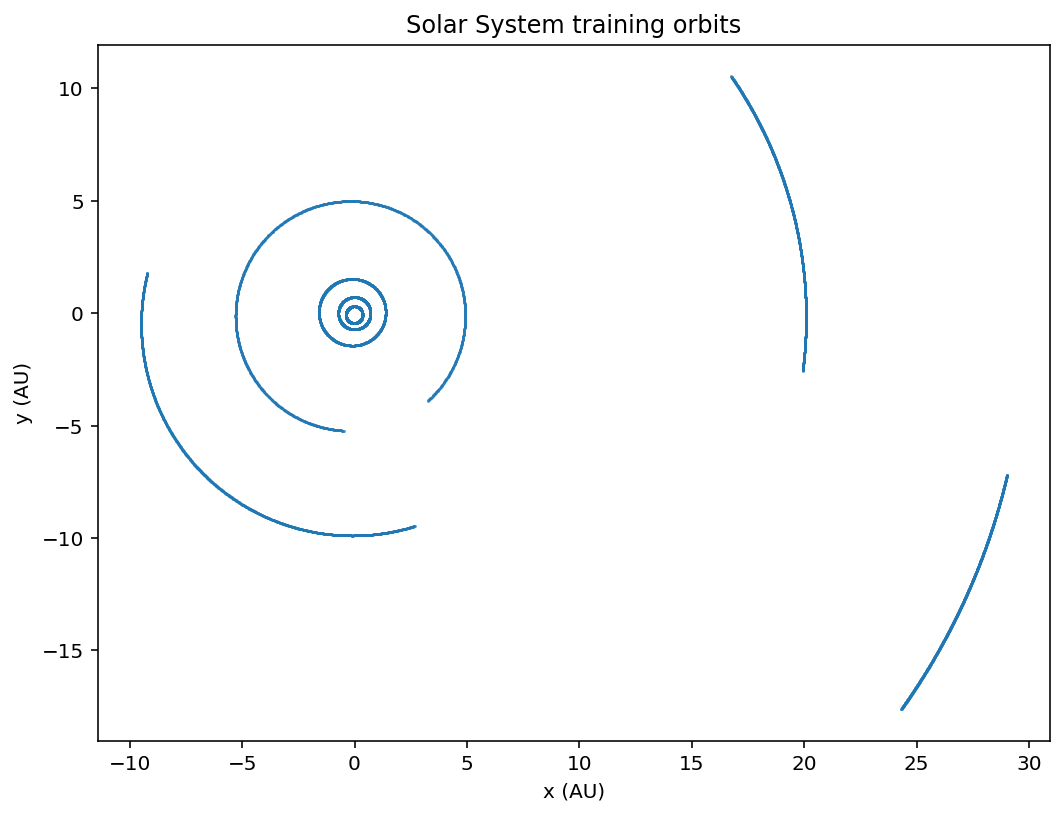

In [1]:
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint

# batch size
ts_size = 20

device = torch.device('cuda:' + str(0) if torch.cuda.is_available() else 'cpu')


class ODEFunc(nn.Module):
    """
    Neural Net of the ODE function
    
    4 inputs [r, phi, vr, vphi] -> 4 outputs [vr, vphi, ar, aphi]
    """
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(nn.Linear(4, 16), 
                                 nn.ReLU(),
                                 nn.Linear(16, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, 16),
                                 nn.ReLU(),
                                 nn.Linear(16, 4)).to(device)

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

    
def get_batch():
    # randomly choosing 64 starting index in planet, time index
    s = torch.from_numpy(np.random.choice(np.arange(size - ts_size, dtype=np.int64), 64, replace=False))
    rand_planet = np.random.randint(0, 7, 64)
    batch_y0 = torch.Tensor(true_y[rand_planet][:, s, :])  # (M, D)
    batch_t = torch.Tensor(t[:ts_size])  # (T)
    batch_y = torch.Tensor(torch.stack([torch.Tensor(true_y[rand_planet][:, s+i, :]) for i in range(ts_size)], dim=0))  # (T, M, D)
    return batch_y0, batch_t, batch_y

ii = 0

func = ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
end = time.time()

r = (o_earth.R(t*u.yr)*u.kpc).to(u.AU)
phi = o_earth.phi(t*u.yr)
x = r*np.cos(phi)
y = r*np.sin(phi)

x2 = (os.x(t*u.yr)*u.kpc).to(u.AU)
y2 = (os.y(t*u.yr)*u.kpc).to(u.AU)

for itr in range(1, 150 + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0.to(device), batch_t.to(device))
    loss = torch.mean(torch.abs(pred_y - batch_y.to(device))).to(device)
    loss.backward()
    optimizer.step()

    if itr % 10 == 0:
        with torch.no_grad():
            pred_y = odeint(func, torch.Tensor(earth_y0).to(device), torch.Tensor(np.linspace(0, 1, size)).to(device))
            loss = torch.mean(torch.abs(pred_y - torch.Tensor(true_y).to(device))).to(device)
            pred = pred_y.detach().cpu().numpy()
            pred_x_pos = pred[:, 0]*np.cos(pred[:, 1])
            pred_y_pos = pred[:, 0]*np.sin(pred[:, 1])
            print(f'Iteration: {itr} | Total Loss {loss.item():.6f}')
            ii += 1
        fig = plt.figure(figsize=(5, 5))
        ax = fig.gca()
        plt.title(f"Iteration {itr}")
        plt.plot(x, y, label='galpy (Earth)')
        plt.plot(pred_x_pos, pred_y_pos, ls='--', label='Prediction (Earth)')
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xlabel("x (AU)")
        plt.ylabel("y (AU)")
        plt.legend()
        ax.set_aspect('equal')
        plt.show()
        plt.close("all")

    end = time.time()

Iteration: 10 | Total Loss 19.302515


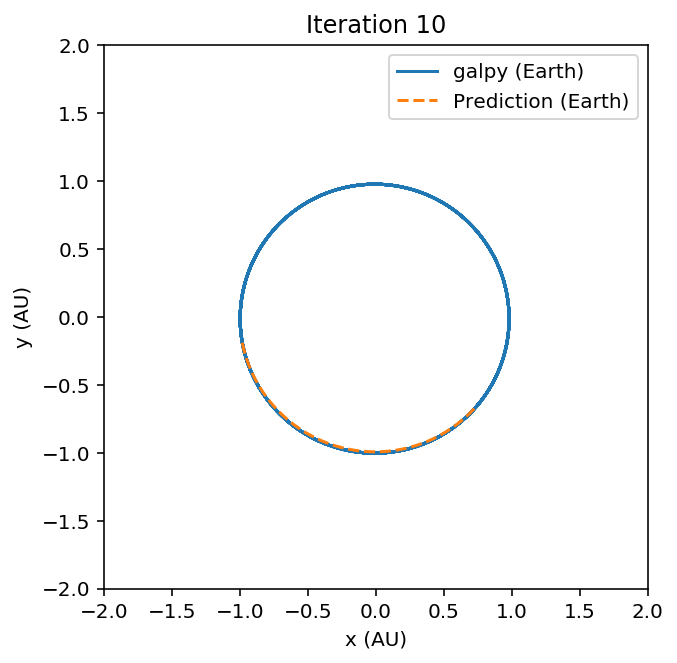

Iteration: 20 | Total Loss 19.030331


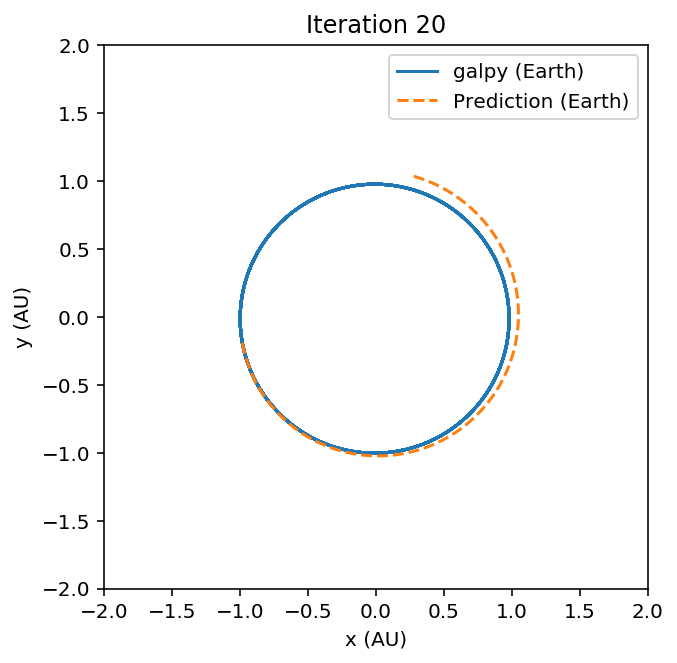

Iteration: 30 | Total Loss 18.903149


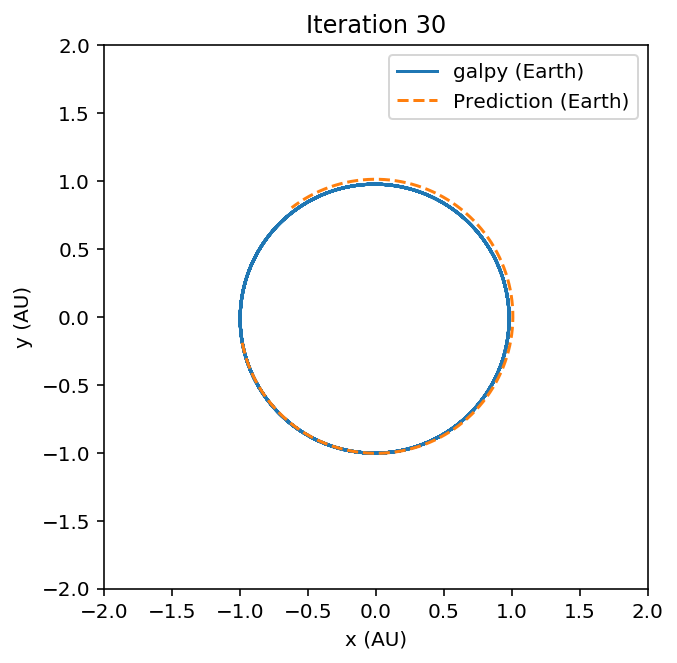

Iteration: 40 | Total Loss 18.847124


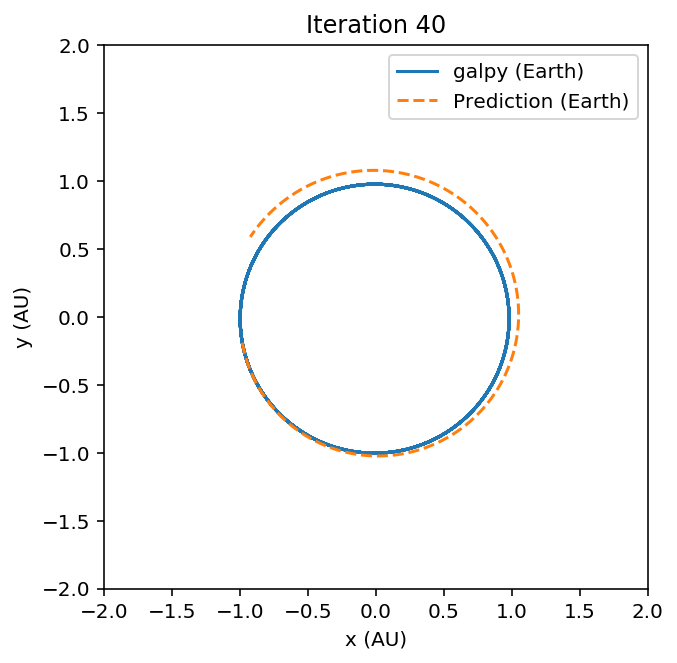

Iteration: 50 | Total Loss 18.797003


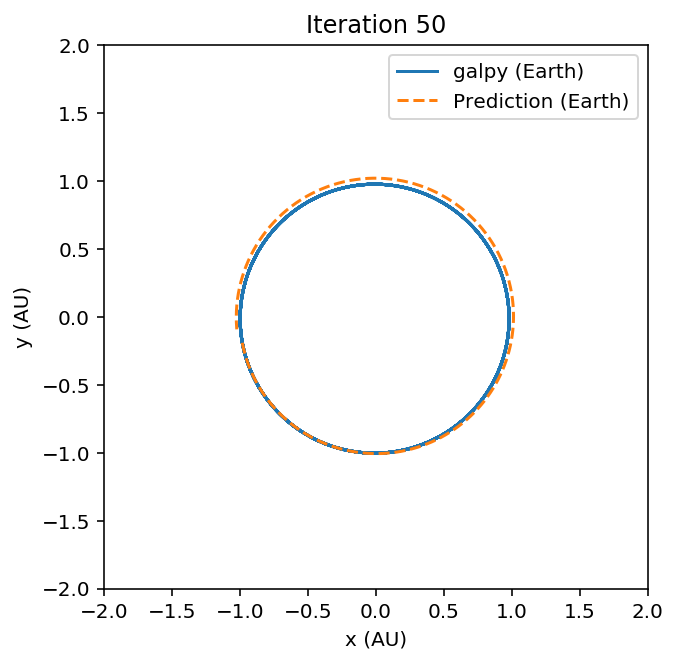

Iteration: 60 | Total Loss 18.818151


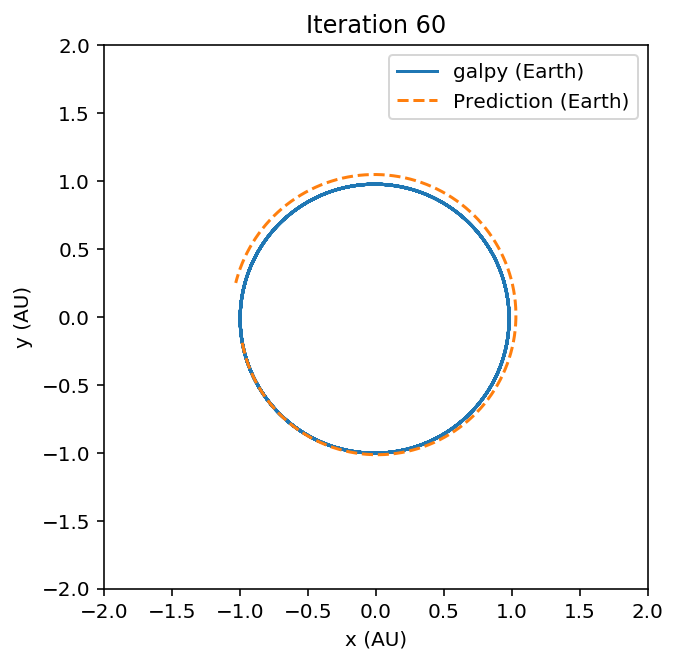

Iteration: 70 | Total Loss 18.794737


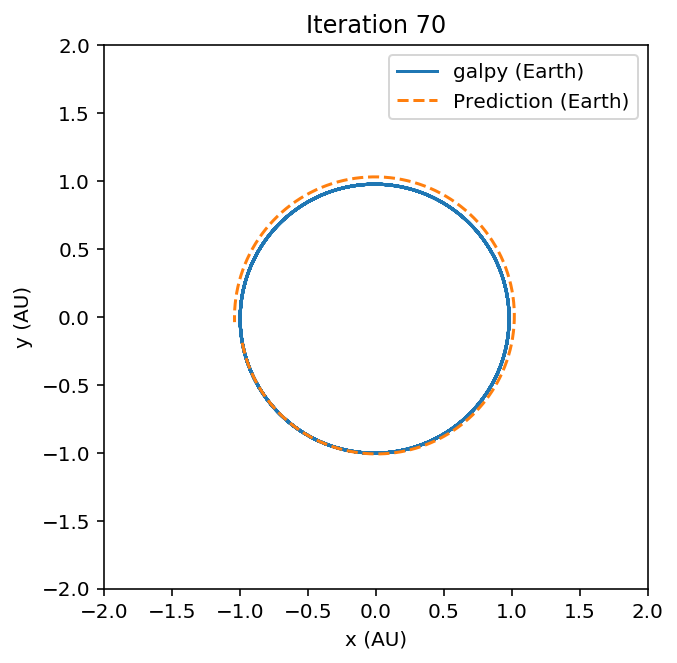

Iteration: 80 | Total Loss 18.789829


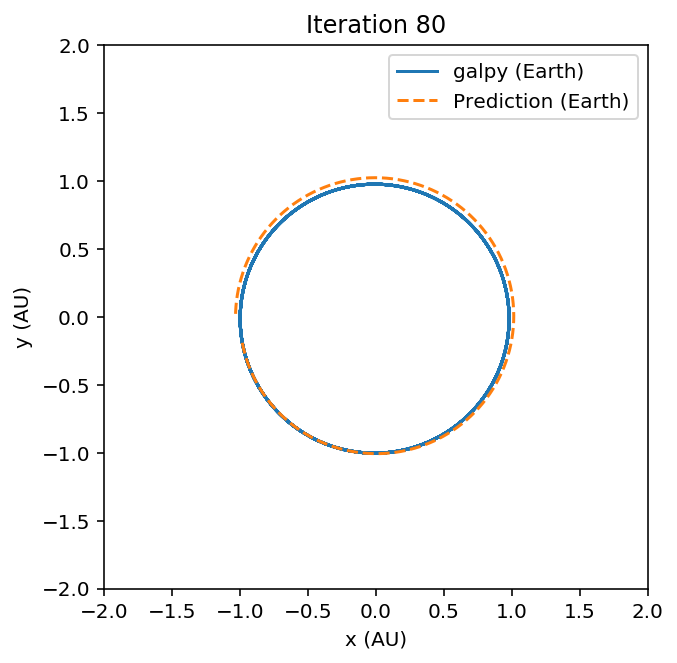

Iteration: 90 | Total Loss 18.795763


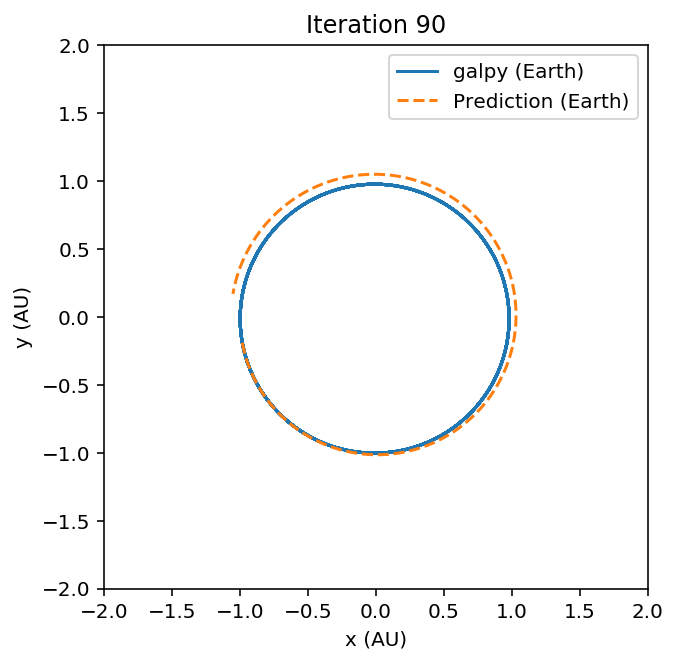

Iteration: 100 | Total Loss 18.805738


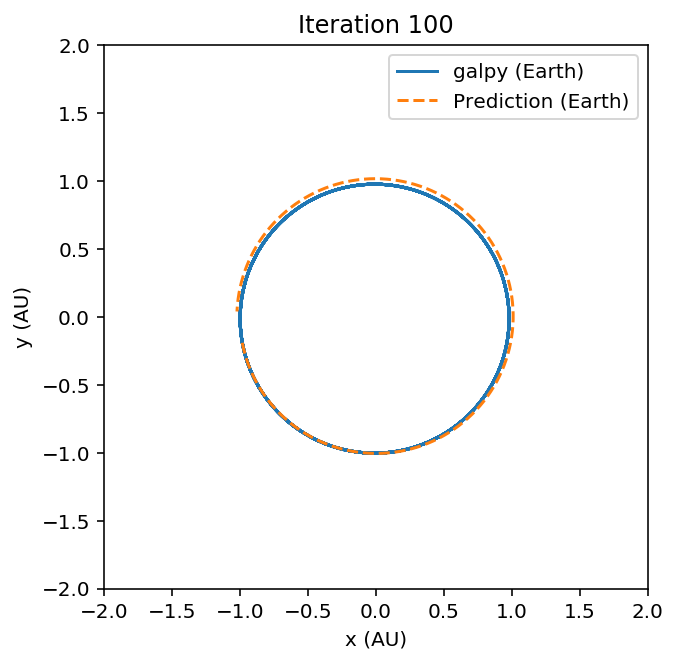

Iteration: 110 | Total Loss 18.822414


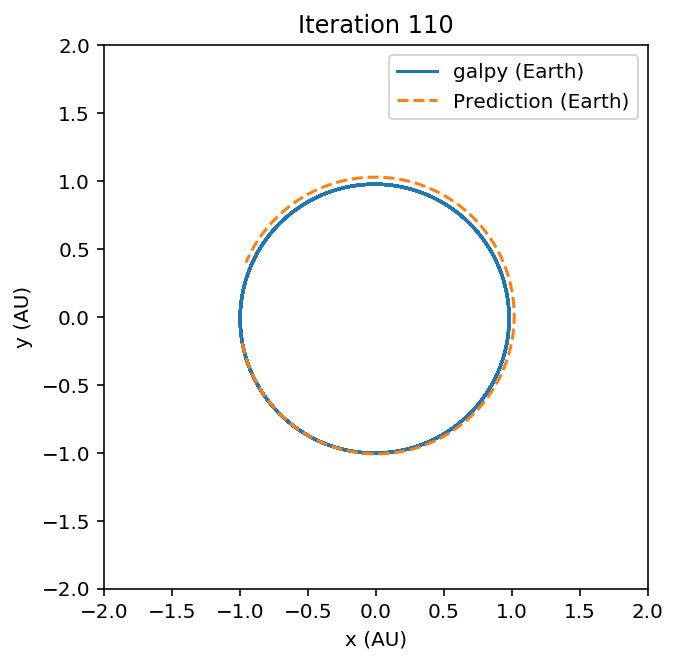

Iteration: 120 | Total Loss 18.798094


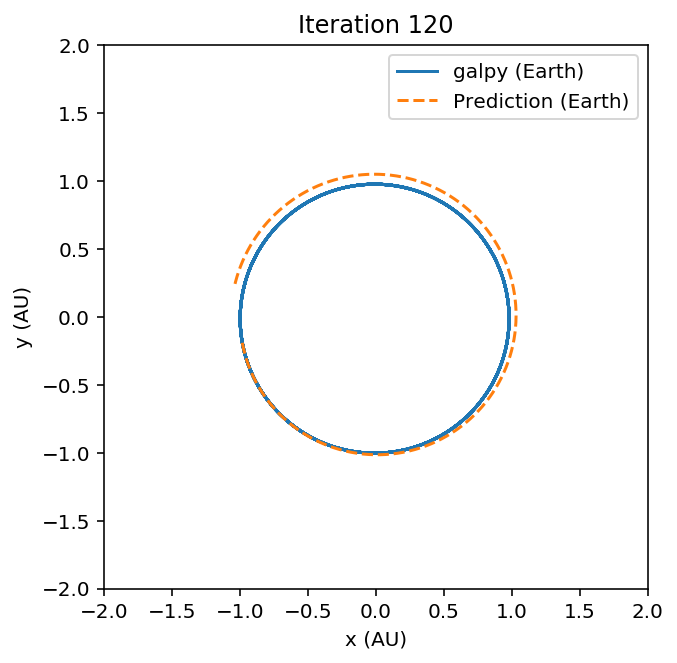

Iteration: 130 | Total Loss 18.790628


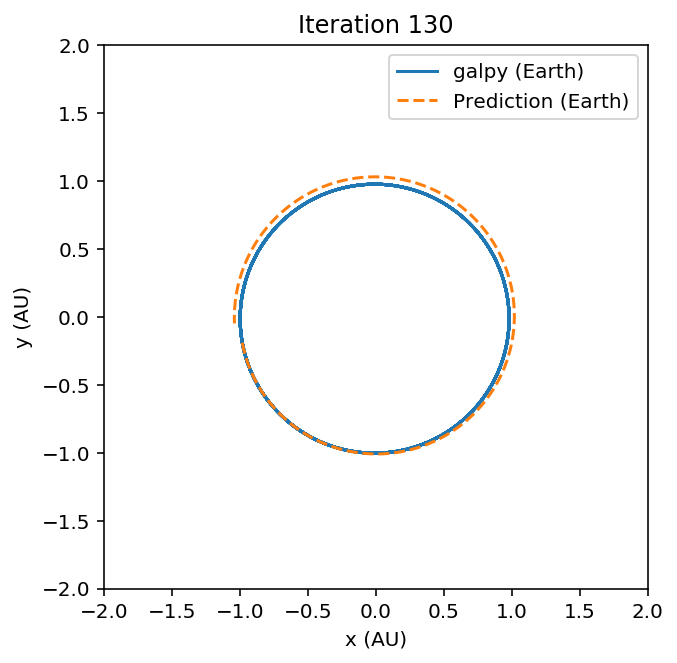

Iteration: 140 | Total Loss 18.810417


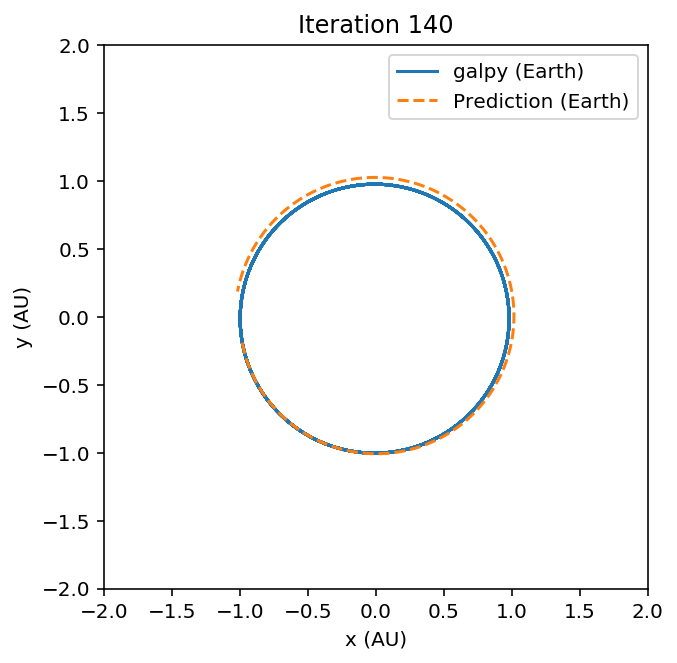

Iteration: 150 | Total Loss 18.797684


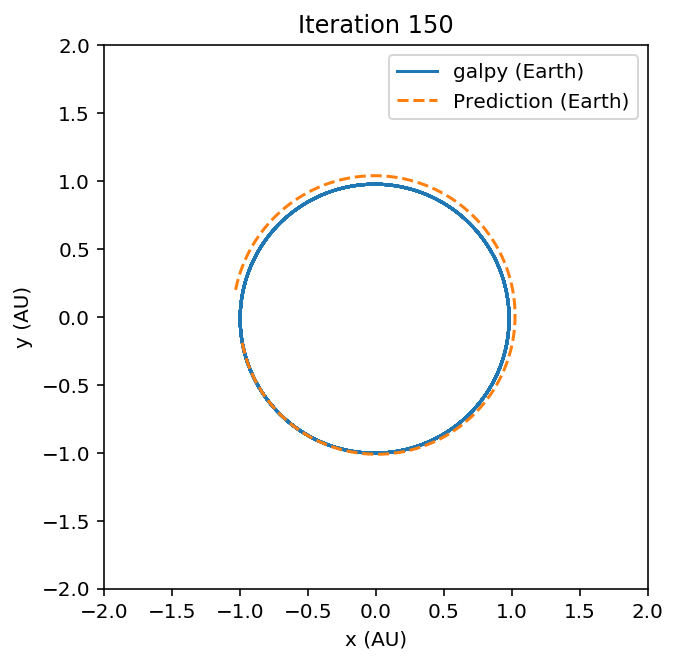

In [2]:
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint

# batch size
ts_size = 20

device = torch.device('cuda:' + str(0) if torch.cuda.is_available() else 'cpu')


class ODEFunc(nn.Module):
    """
    Neural Net of the ODE function
    
    4 inputs [r, phi, vr, vphi] -> 4 outputs [vr, vphi, ar, aphi]
    """
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(nn.Linear(4, 16), 
                                 nn.ReLU(),
                                 nn.Linear(16, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, 16),
                                 nn.ReLU(),
                                 nn.Linear(16, 4)).to(device)

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

    
def get_batch():
    # randomly choosing 64 starting index in planet, time index
    s = torch.from_numpy(np.random.choice(np.arange(size - ts_size, dtype=np.int64), 64, replace=False))
    rand_planet = np.random.randint(0, 7, 64)
    batch_y0 = torch.Tensor(true_y[rand_planet][:, s, :])  # (M, D)
    batch_t = torch.Tensor(t[:ts_size])  # (T)
    batch_y = torch.Tensor(torch.stack([torch.Tensor(true_y[rand_planet][:, s+i, :]) for i in range(ts_size)], dim=0))  # (T, M, D)
    return batch_y0, batch_t, batch_y

ii = 0

func = ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
end = time.time()

r = (o_earth.R(t*u.yr)*u.kpc).to(u.AU)
phi = o_earth.phi(t*u.yr)
x = r*np.cos(phi)
y = r*np.sin(phi)

x2 = (os.x(t*u.yr)*u.kpc).to(u.AU)
y2 = (os.y(t*u.yr)*u.kpc).to(u.AU)

for itr in range(1, 150 + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0.to(device), batch_t.to(device))
    loss = torch.mean(torch.abs(pred_y - batch_y.to(device))).to(device)
    loss.backward()
    optimizer.step()

    if itr % 10 == 0:
        with torch.no_grad():
            pred_y = odeint(func, torch.Tensor(earth_y0).to(device), torch.Tensor(np.linspace(0, 1, size)).to(device))
            loss = torch.mean(torch.abs(pred_y - torch.Tensor(true_y).to(device))).to(device)
            pred = pred_y.detach().cpu().numpy()
            pred_x_pos = pred[:, 0]*np.cos(pred[:, 1])
            pred_y_pos = pred[:, 0]*np.sin(pred[:, 1])
            print(f'Iteration: {itr} | Total Loss {loss.item():.6f}')
            ii += 1
        fig = plt.figure(figsize=(5, 5))
        ax = fig.gca()
        plt.title(f"Iteration {itr}")
        plt.plot(x, y, label='galpy (Earth)')
        plt.plot(pred_x_pos, pred_y_pos, ls='--', label='Prediction (Earth)')
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xlabel("x (AU)")
        plt.ylabel("y (AU)")
        plt.legend()
        ax.set_aspect('equal')
        plt.show()
        plt.close("all")

    end = time.time()